In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from skater.core.local_interpretation.text_interpreter import auto_feature_selection, query_top_features_in_doc, \
query_top_features_overall, query_top_features_by_class, understand_estimator, \
relevance_wt_assigner, vectorize_as_tf_idf, get_feature_names
from skater.core.visualizer.relevance_visualizer import build_explainer, generate_word_cloud, show_in_notebook
from skater.util.text_ops import preprocessor
from skater.util.plotting import plot_from_df
from skater.util.text_ops import query_for_false_predictions
from skater.util.dataops import convert_dataframe_to_dict

from IPython.core.debugger import set_trace

In [2]:
categories = [
    'rec.autos',
    'rec.motorcycles'
]
remove = ('headers', 'footers', 'quotes')

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                     shuffle=True, random_state=0,
                                     remove=remove)

In [3]:
X_train = data_train.data
y_train = data_train.target

In [4]:
X_train[0]

"This morning a truck that had been within my sight (and I within\nhis) for about 3 miles suddenly forgot that I existed and pulled\nover right on me -- my front wheel was about even with the back\nedge of his front passenger door as I was accelerating past him.\n\nIt was trivial enough for me to tap the brakes and slide behind him\nas he slewed over (with no signal, of course) on top of me, with\nmy little horn blaring (damn, I need Fiamms!), but the satisfaction\nof being aware of my surroundings and thus surviving was not enough,\nespecially when I later pulled up alongside the bastard and he made\nno apologetic wave or anything.\n\nIs there some way that I can memorize the license plate of an\noffending vehicle and get the name and address of the owner?\nI'm not going to firebomb houses or anything, I'd just like to\nwrite a consciousness-raising letter or two. I think that it would\nbe good for BDI cagers to know that We Know Where They Live.\nMaybe they'd use 4 or 5 brain cells w

In [5]:
data_test = fetch_20newsgroups(subset='test', categories=categories,
                                     shuffle=True, random_state=0,
                                     remove=remove)
X_test = data_test.data
y_test = data_test.target

In [6]:
X_train = [preprocessor(t) for t in X_train]
print(X_train[0])

this morning a truck that had been within my sight and i within his for about 3 miles suddenly forgot that i existed and pulled over right on me my front wheel was about even with the back edge of his front passenger door as i was accelerating past him it was trivial enough for me to tap the brakes and slide behind him as he slewed over with no signal of course on top of me with my little horn blaring damn i need fiamms but the satisfaction of being aware of my surroundings and thus surviving was not enough especially when i later pulled up alongside the bastard and he made no apologetic wave or anything is there some way that i can memorize the license plate of an offending vehicle and get the name and address of the owner i m not going to firebomb houses or anything i d just like to write a consciousness raising letter or two i think that it would be good for bdi cagers to know that we know where they live maybe they d use 4 or 5 brain cells while driving instead of the usual 3  


In [7]:
# define param_dict for TfIdf Vectorizer
param_dict = {
    'sublinear_tf':True, 
    'max_df': 0.5,
    'stop_words': 'english', 
    'smooth_idf': True,
    'ngram_range':(1, 3),
    #'max_features': 10 (didn't give the right result)
}
vectorizer, X_train = vectorize_as_tf_idf(X_train, **param_dict)
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 1192, n_features: 126384


In [8]:
# Names of all the features extracted
feature_names =  get_feature_names(vectorizer_inst=vectorizer)
print(len(feature_names))

126384


Class:rec.motorcycles


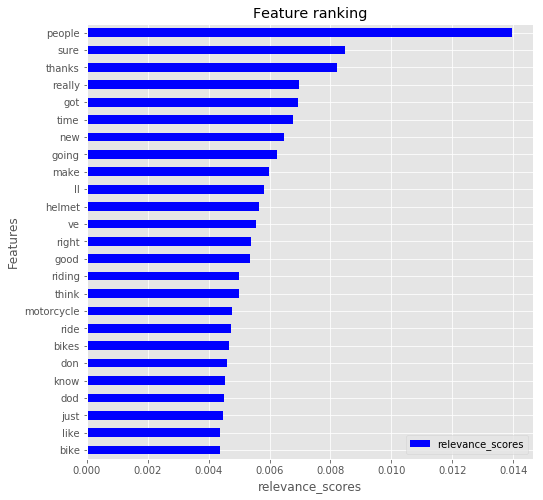

In [9]:
# 1. First Query: What are the top TF-IDF features in the training corpus
print("Class:{}".format(categories[1]))
t_df = query_top_features_by_class(X=X_train, y=y_train, feature_names=feature_names, class_index=1, 
                                   min_threshold=0.0001)

plot_from_df(t_df, 'relevance_scores', 'relevance_scores', 'Features')

Class:rec.motorcycles


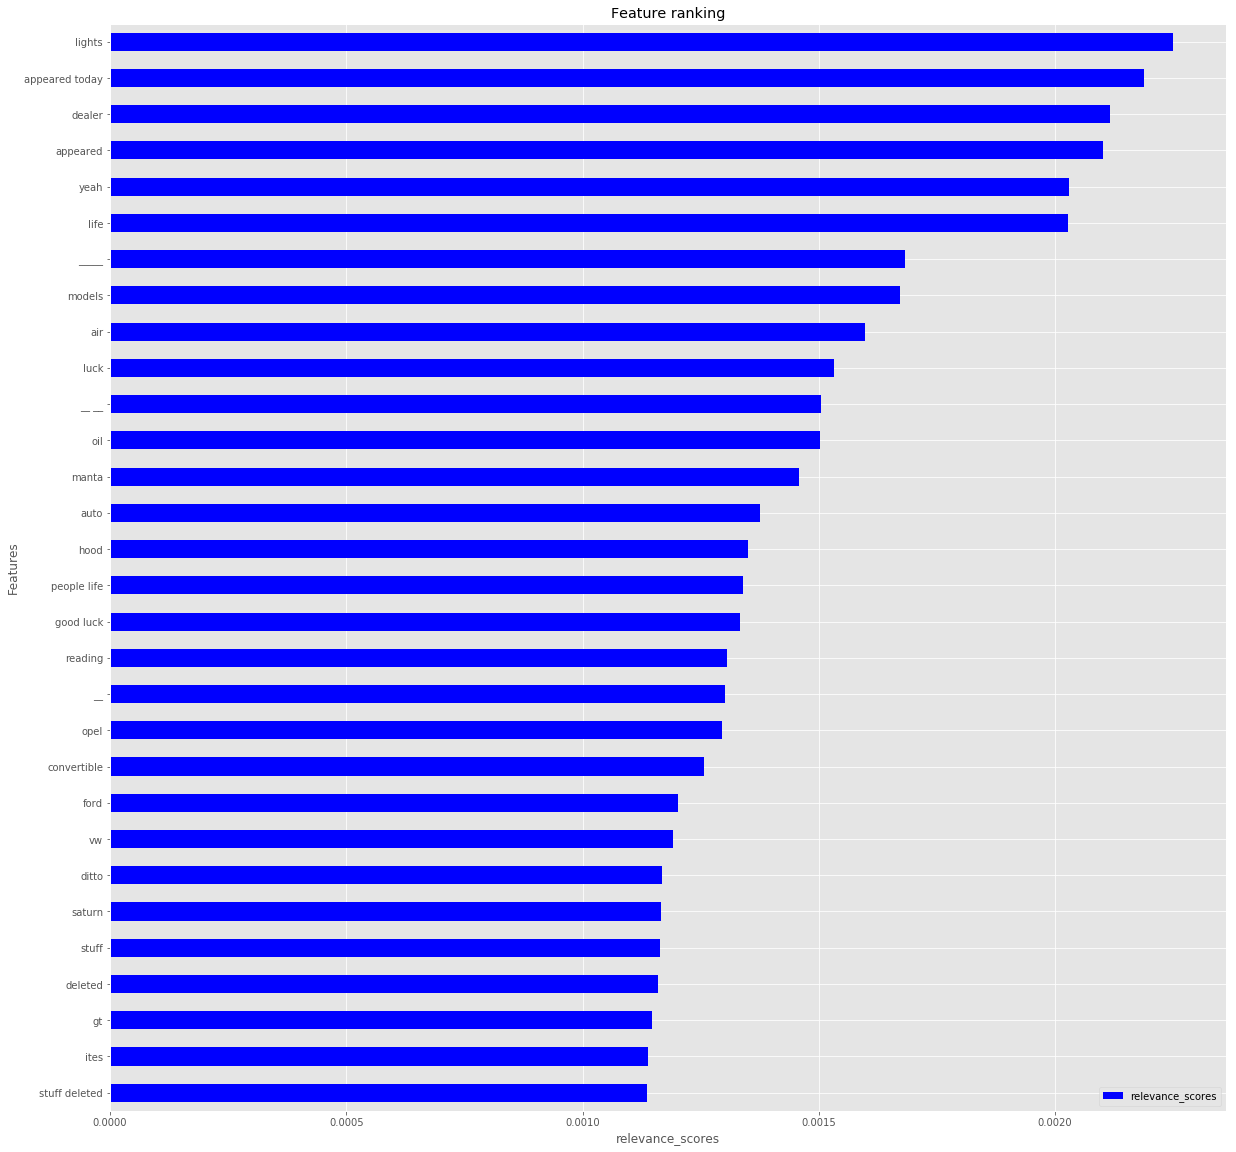

In [10]:
# 1. Query by Class
print("Class:{}".format(categories[1]))
df = query_top_features_by_class(X=X_train, y=y_train, feature_names=feature_names, class_index=0, 
                                                       summarizer_type='mean', topk_features=30, min_threshold=0.1)
plot_from_df(df, 'relevance_scores', 'relevance_scores', 'Features', display_size=(20,20))

Target Catgeory:rec.autos


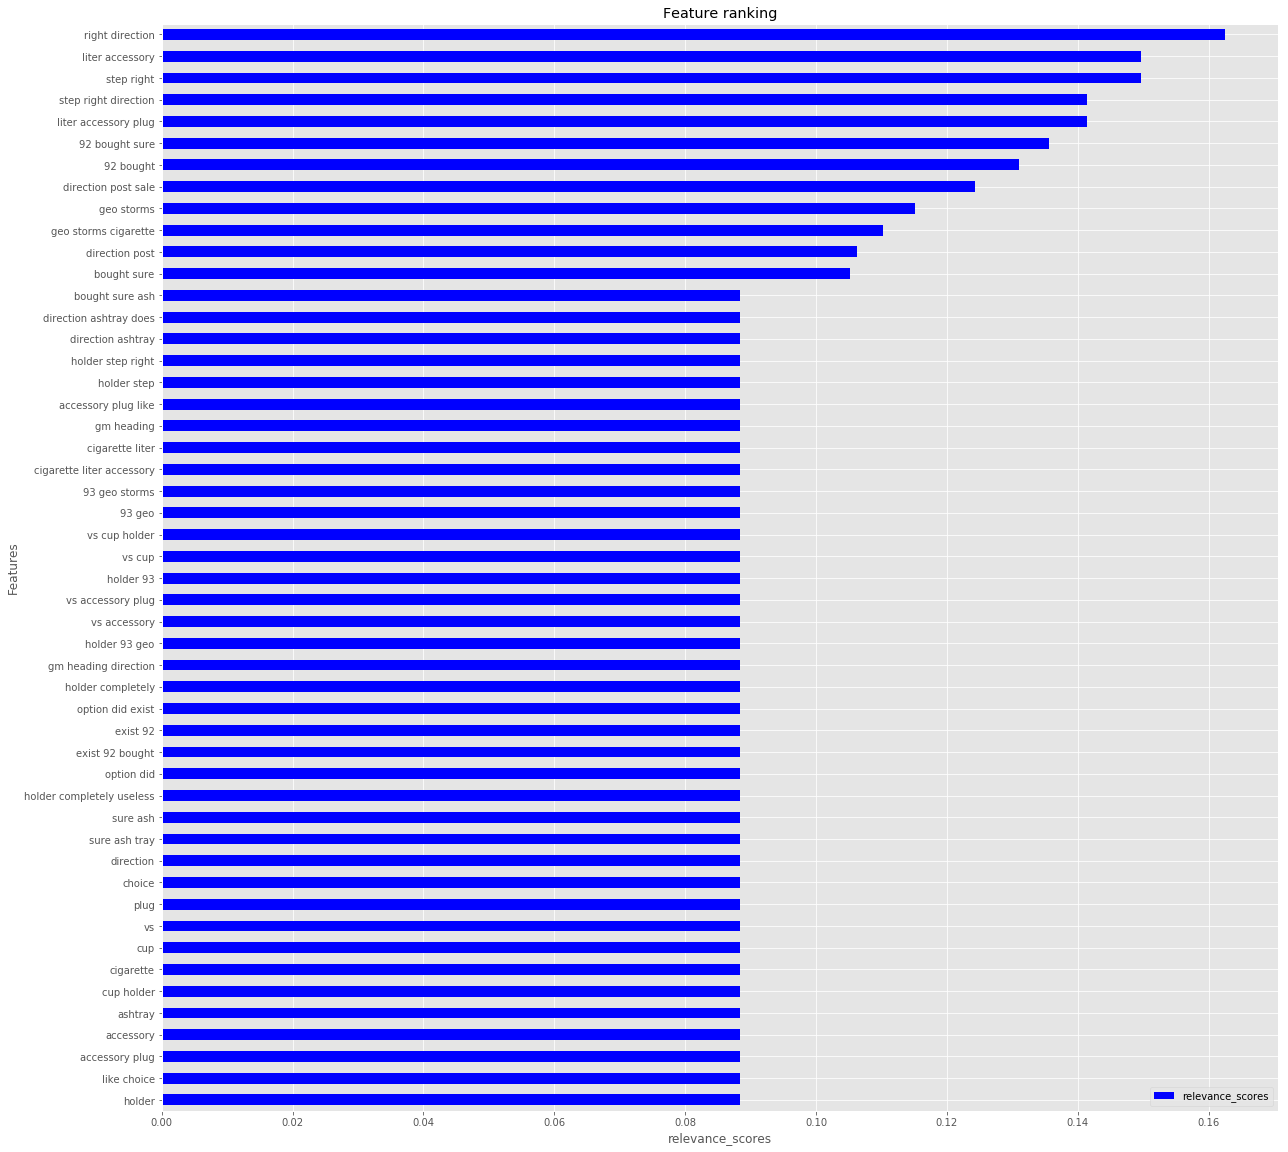

In [11]:
# 2. Query features at the document level
from random import randint
row_index = randint(0, 3000)
print("Target Catgeory:{}".format(categories[y_train[1]]))
feature_per_doc = query_top_features_in_doc(data=X_train[1], y=None, features=feature_names, 
                                        feature_selection_choice='default', top_k=50)
plot_from_df(feature_per_doc, 'relevance_scores', 'relevance_scores', 'Features', display_size=(20,20))

Classes:['rec.autos', 'rec.motorcycles']


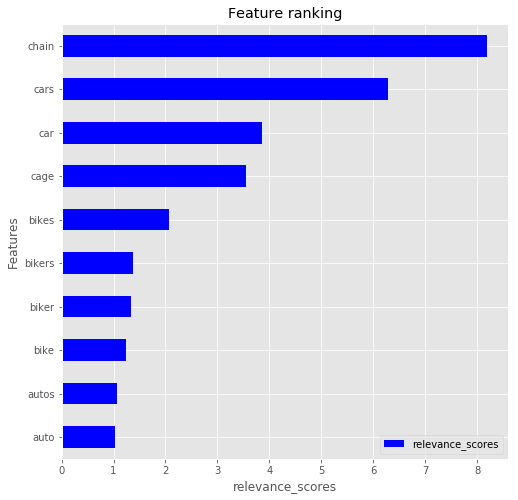

In [12]:
# 3. Query for top features that are important in the whole training corpus
print("Classes:{}".format(categories))
with_feature_selection_df = query_top_features_overall(data=X_train, y_true=y_train, feature_list=feature_names, 
                                    feature_selection='chi2', min_threshold=0.0001, top_k=50)

plot_from_df(with_feature_selection_df.head(10), 'relevance_scores', 'relevance_scores', 'Features')

In [13]:
print(data_train.data[1])
print("Target Category Class:{}".format(categories[data_train.target[1]]))
relevance_wts_per_doc = convert_dataframe_to_dict('features', 'relevance_scores', feature_per_doc)
build_explainer(data_train.data[1], relevance_wts_per_doc, highlight_oov=True)
show_in_notebook('./rendered.html')


GM, at least, is heading in that direction.  One of the post-sale
questions they asked me was if I'd like the choice of a cigarette
liter or an accessory plug, and another whether I'd like the choice of
an ashtray or a cup holder.

The '93 Geo Storms have the cigarette lighter vs accessory plug option
(which did not exist in the '92 I bought) -- I'm not sure about the
ash tray vs cup holder.  It's a step in the right direction.

The ashtray does make a convenient change-holder so it's not
completely useless.
Target Category Class:rec.autos


In [14]:
# Visualizing the influence of top features post feature selection at the Doc level
# This might become very useful, when one is doing exploratory analysis
# Observation: None of the top features are part of this document. Such form of intuitive 
# observation becomes very useful for a non-technical person.

print(data_train.data[1])
print("Target Category Class:{}".format(categories[data_train.target[1]]))

relevance_wts_per_doc = convert_dataframe_to_dict('features', 'relevance_scores', with_feature_selection_df)
build_explainer(data_train.data[1], relevance_wts_per_doc, highlight_oov=True)
show_in_notebook('./rendered.html')


GM, at least, is heading in that direction.  One of the post-sale
questions they asked me was if I'd like the choice of a cigarette
liter or an accessory plug, and another whether I'd like the choice of
an ashtray or a cup holder.

The '93 Geo Storms have the cigarette lighter vs accessory plug option
(which did not exist in the '92 I bought) -- I'm not sure about the
ash tray vs cup holder.  It's a step in the right direction.

The ashtray does make a convenient change-holder so it's not
completely useless.
Target Category Class:rec.autos


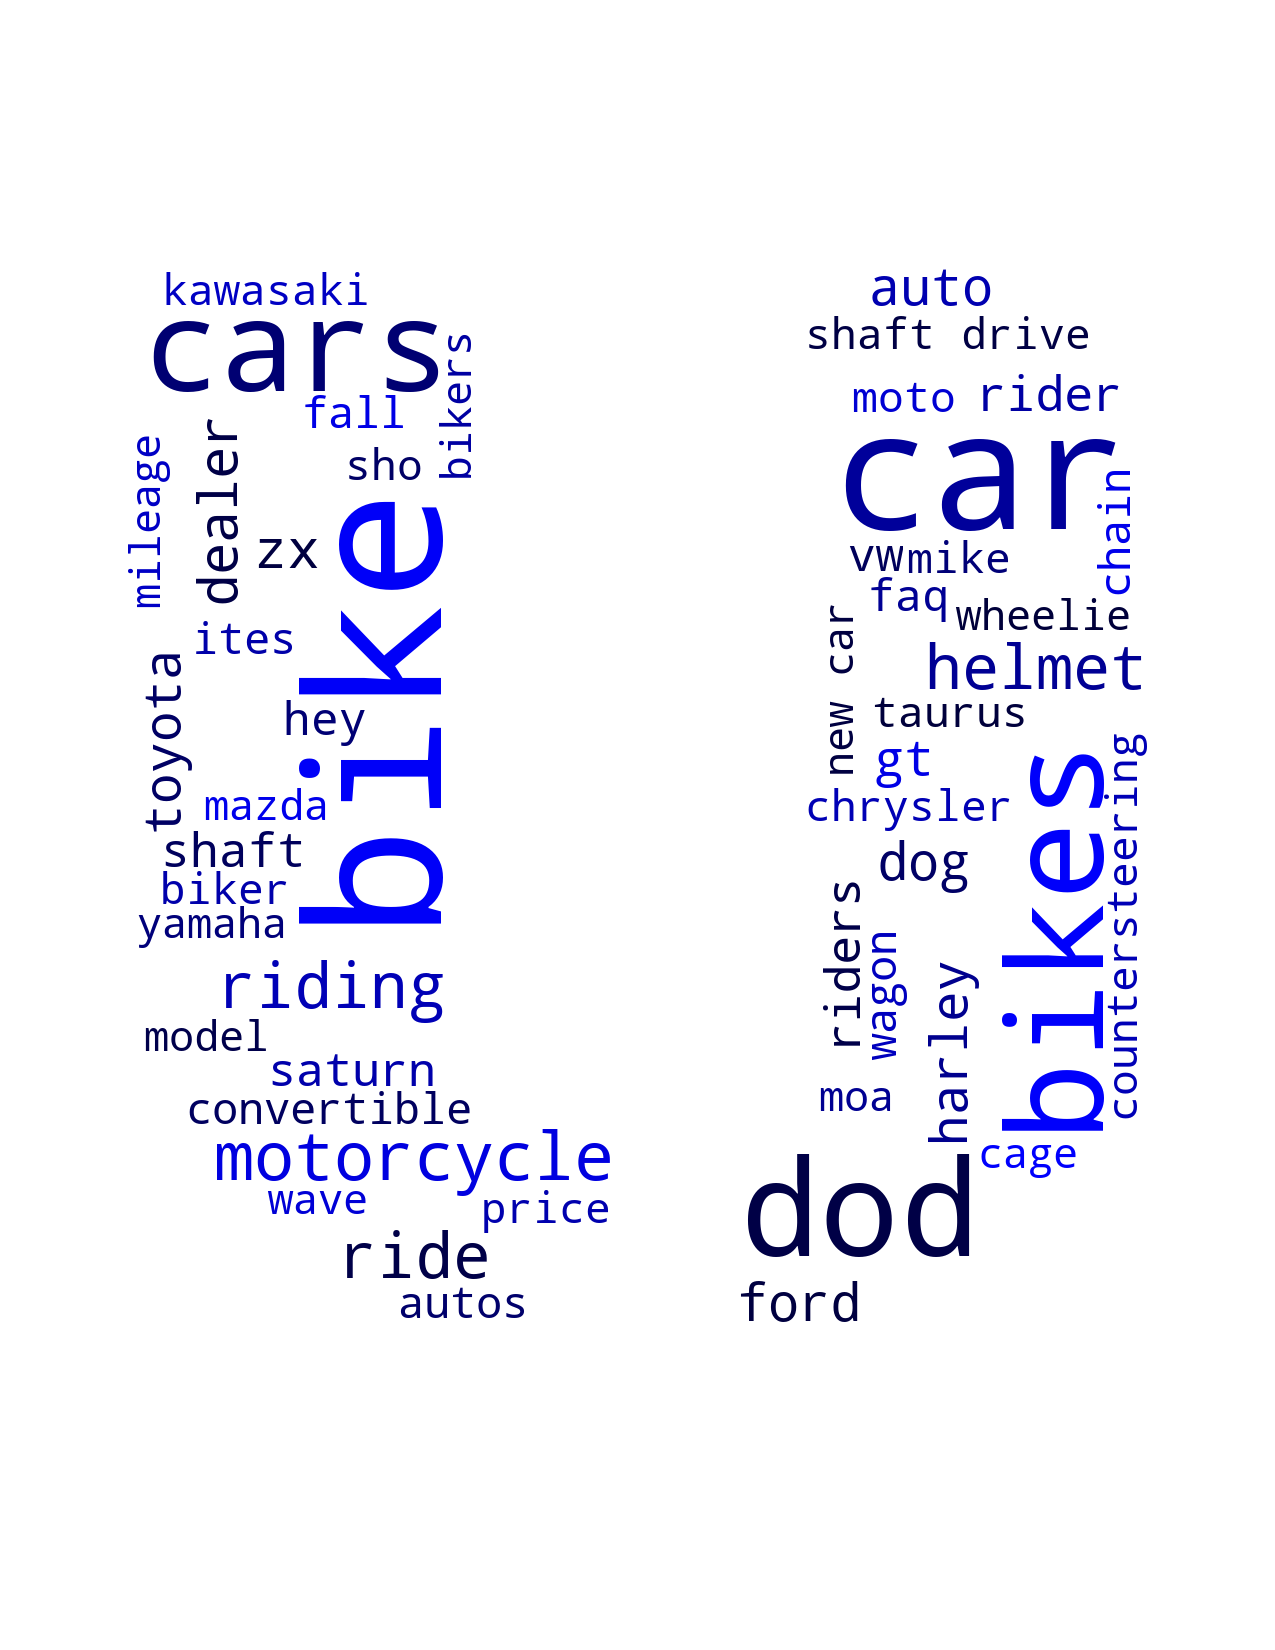

In [15]:
# Visualzing word relevance at document level
# One can easily change the stencil to other figures
w_c = generate_word_cloud(relevant_feature_wts=relevance_wts_per_doc, mask_filename='./letter-u-stencil.png')
show_in_notebook('./word_cloud.png')

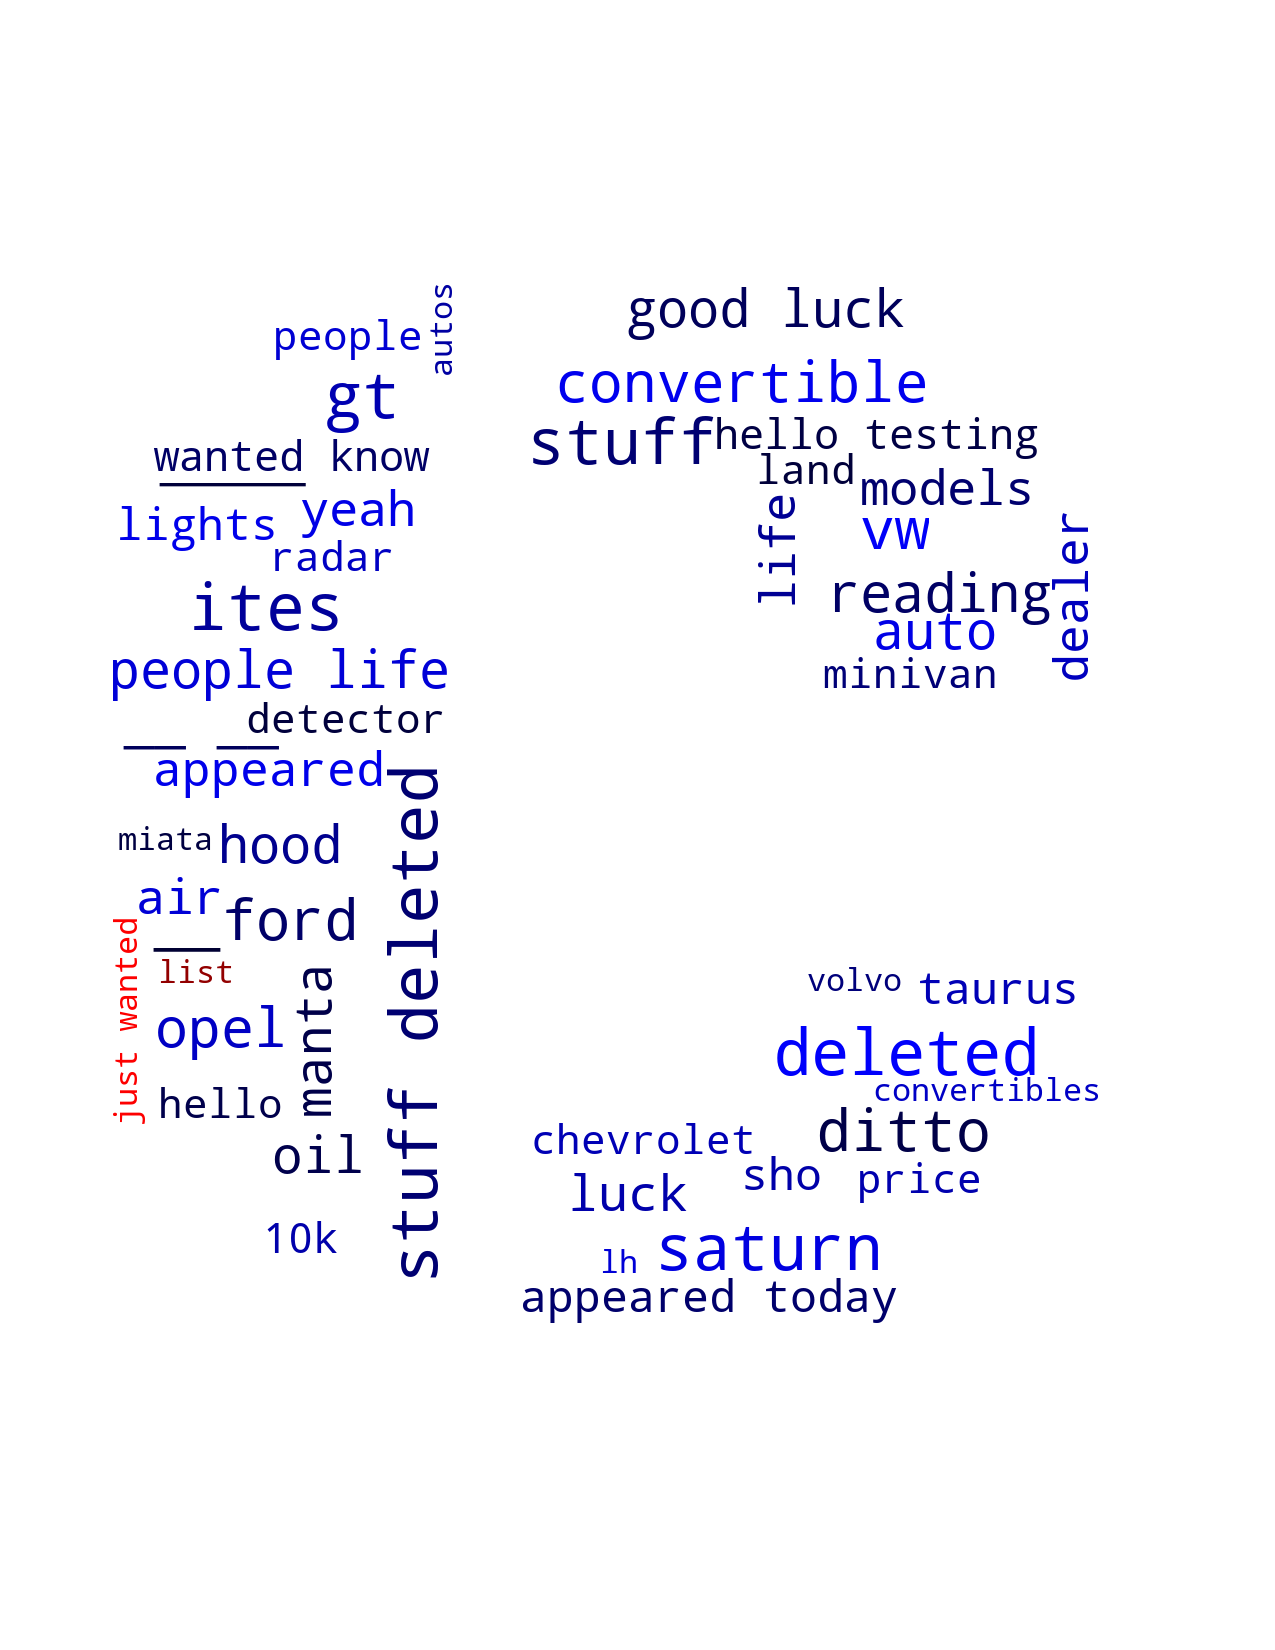

In [16]:
# Realizing word relevance at class level
df_class_rec_autos = query_top_features_by_class(X=X_train, y=y_train, feature_names=feature_names, 
                                                          class_index=0, summarizer_type='mean', topk_features=50, 
                                                          min_threshold=0.1)
relevance_wts_for_class_autos = convert_dataframe_to_dict('features', 'relevance_scores', df_class_rec_autos)
# One can change easily change stencil to other figures
w_c = generate_word_cloud(relevant_feature_wts=relevance_wts_for_class_autos, mask_filename='./letter-c-stencil.png', 
                          threshold=0.001)
show_in_notebook('./word_cloud.png')

In [17]:
df_class_rec_motorcycles = query_top_features_by_class(X=X_train, y=y_train, feature_names=feature_names, 
                                                          class_index=1, summarizer_type='mean', topk_features=50, 
                                                          min_threshold=0.1)
relevance_wts_for_class_motorcycles = convert_dataframe_to_dict('features', 'relevance_scores', df_class_rec_motorcycles)

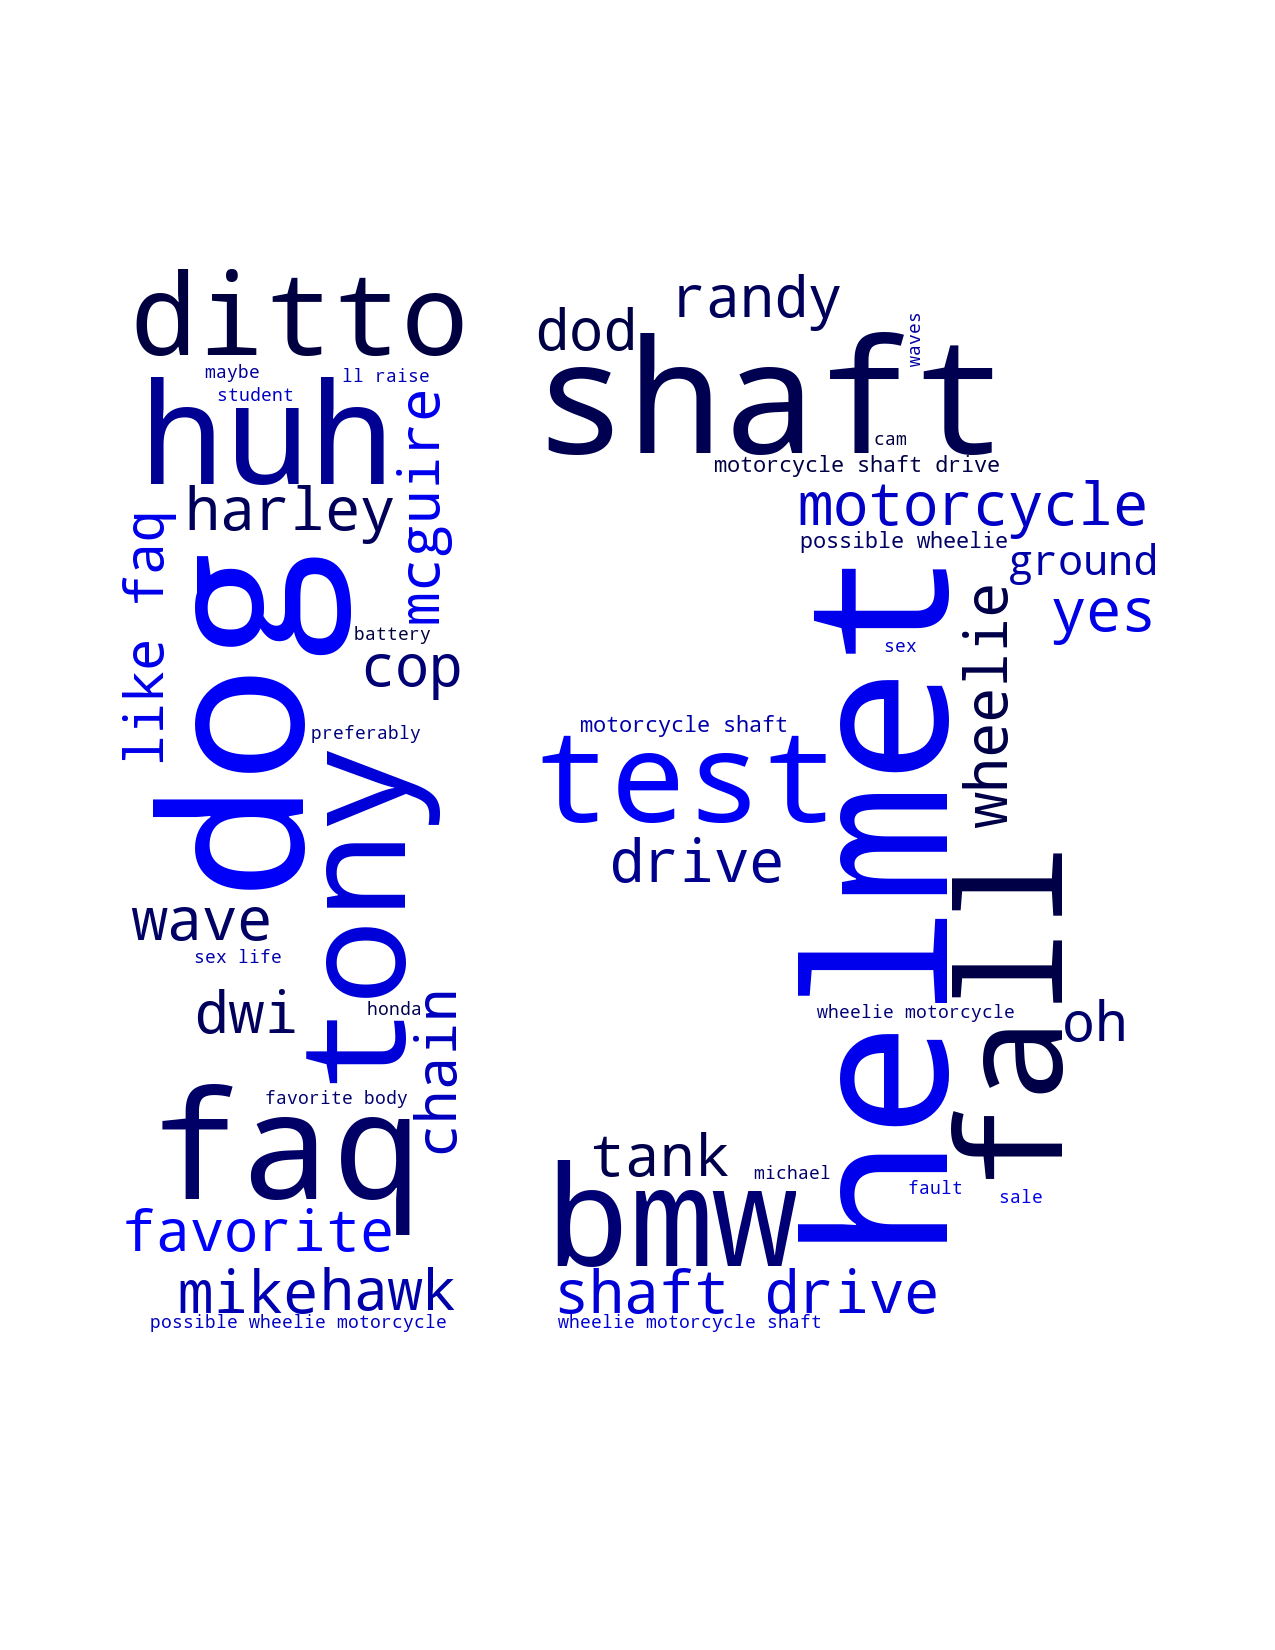

In [18]:
w_c = generate_word_cloud(relevant_feature_wts=relevance_wts_for_class_motorcycles, mask_filename='./letter-b-stencil.png', 
                          threshold=0.001)
show_in_notebook('./word_cloud.png')

# Observations: 
Just visualizing the tranformed features wts.,in different forms, might be misleading because an 
tranformed feature wts just represent the importance in-regards to the corpus which might not consider its respective
influence on the predictive class.

# Build a Classifier:

In [19]:
# Select the top 'k' feature post feature selection
select_type_inst, X_new_train, selected_feature = auto_feature_selection(X_train, y_train, 
                                                                             feature_names=feature_names)
print(len(selected_feature))

126384


In [20]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet", loss='log', random_state=1)
clf.fit(X_new_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=50,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=1,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [21]:
# Compute confusion matrix
y_pred = clf.predict(X_new_train)
score = metrics.accuracy_score(y_train, y_pred)
print("accuracy:{}".format(score))

accuracy:0.9865771812080537


In [22]:
# On test dataset
X_new_test = vectorizer.transform(X_test)
X_new_test = select_type_inst.transform(X_new_test)

y_pred_test = clf.predict(X_new_test)
score = metrics.accuracy_score(y_test, y_pred_test)
print("accuracy:{}".format(score))

accuracy:0.8841309823677582


In [23]:
# Filter all the in-correct prediction
import numpy as np
incorrect_indexes = query_for_false_predictions(y_pred_test, y_test)
# Query for some indexes 
incorrect_indexes[0][0:53]

array([ 12,  14,  26,  32,  35,  40,  55,  73,  75,  76, 101, 104, 121,
       143, 144, 150, 154, 167, 174, 181, 186, 192, 222, 227, 239, 243,
       244, 247, 270, 272, 283, 288, 292, 312, 319, 341, 343, 344, 355,
       360, 369, 388, 401, 414, 415, 426, 430, 436, 440, 450, 455, 476, 478])

In [24]:
evaluate_index = 360
print("Gold Label(index):{}({})".format(categories[y_test[evaluate_index]], y_test[evaluate_index]))
print("Predicted Label(index):{}({})".format(categories[y_pred_test[evaluate_index]], y_pred_test[evaluate_index]))
print("---------------------------------------------")
print("Document:{}".format(X_test[evaluate_index]))

Gold Label(index):rec.motorcycles(1)
Predicted Label(index):rec.autos(0)
---------------------------------------------
Document:


Sounds like you are getting a pretty fair price (assuming it is in
nice condition)




In [38]:
# So, when using SLRP there might be a reduction in the number of features
# While using default coefficients, features by class is not needed, those are derived from the coefficients themselves
features_to_consider = query_top_features_by_class(X_new_train, y_train, selected_feature, class_index=0, 
                                                    topk_features=len(selected_feature), 
                                                    summarizer_type='mean', min_threshold=0.1)

relevance_dict, relevance_df, _ = understand_estimator(clf, 0, features_to_consider, selected_feature, 
                                             top_k=len(features_to_consider), relevance_type='default')

In [39]:
print(X_test[evaluate_index])
build_explainer(X_test[evaluate_index], relevance_dict, highlight_oov=True, file_name='rendered_predicted')
show_in_notebook(file_name_with_type='rendered_predicted.html')




Sounds like you are getting a pretty fair price (assuming it is in
nice condition)




In [31]:
features_to_consider = query_top_features_by_class(X_new_train, y_train, selected_feature, class_index=0, 
                                                    topk_features=len(selected_feature), 
                                                    summarizer_type='mean', min_threshold=0.1)

relevance_dict, df, _ = understand_estimator(clf, 0, features_to_consider, selected_feature, 
                                             top_k=len(features_to_consider), relevance_type='SLRP')
build_explainer(X_test[evaluate_index], relevance_dict, highlight_oov=True, file_name='rendered_gold_label')
show_in_notebook(file_name_with_type='rendered_gold_label.html')

In [32]:
relevance_dict, df, _ = understand_estimator(clf, 0, None, selected_feature, 
                                             top_k=len(selected_feature), relevance_type='default')

build_explainer(X_test[evaluate_index], relevance_dict, highlight_oov=True, file_name='default_predictor')

show_in_notebook(file_name_with_type='default_predictor.html')

In [33]:
from skater.core.local_interpretation.lime.lime_text import LimeTextExplainer
from sklearn.ensemble import RandomForestClassifier

explainer = LimeTextExplainer(class_names=categories)
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
estm = make_pipeline(vectorizer, select_type_inst, clf)

In [35]:
print("Gold Label(index):{}({})".format(categories[y_test[evaluate_index]], y_test[evaluate_index]))
print("Predicted Label:{}({})".format(categories[estm.predict([X_test[evaluate_index]])[0]],estm.predict([X_test[evaluate_index]])[0]))
print("-------------------------------")
print(X_test[evaluate_index])

Gold Label(index):rec.motorcycles(1)
Predicted Label:rec.autos(0)
-------------------------------



Sounds like you are getting a pretty fair price (assuming it is in
nice condition)




In [36]:
exp = explainer.explain_instance(X_test[evaluate_index], estm.predict_proba, num_features=4)

/home/ubuntu/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [37]:
exp.show_in_notebook(text=True)